In [1]:
import pandas as pd
pd.set_option('display.precision', 3)

import json
import numpy as np
import statistics

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from ipynb.fs.full.graphics import draw_multiple_plots

In [2]:
def get_performance_metrics(filepath):
    with open(filepath) as file:
        contents = file.read()
    parsed_json = json.loads(contents)
    f1 = parsed_json['accuracy_metrics']['f1']
    avg_explanation_time = parsed_json['average_explanation_time']
    return f1, avg_explanation_time

def summarise_performance_metrics(rates, 
                                  possible_root_causes_gt,
                                  num_nodes=6, 
                                  folder=f'windows/branch', 
                                  nslide_used=2,
                                 ):
    result_f1 = {}
    result_avg_exp_time = {}
    target_node = f'X{num_nodes}'
    for rate in rates:
        f1s, exp_times = [], []
        nodes = [f'X{i}' for i in range(1, num_nodes+1)]
        for root_cause_gt in possible_root_causes_gt[num_nodes]:
            bname = f'{num_nodes}_nodes_{root_cause_gt}_{target_node}'
            filename = f'performance_{bname}_{nslide_used}.json'
            filepath = f'{folder}/rate_{rate}/{filename}'
            f1, avg_exp_time = get_performance_metrics(filepath)
            f1s.append(f1)
            exp_times.append(avg_exp_time)
        result_f1[rate] = statistics.mean(f1s)
        result_avg_exp_time[rate] = statistics.mean(exp_times)
    return result_f1, result_avg_exp_time

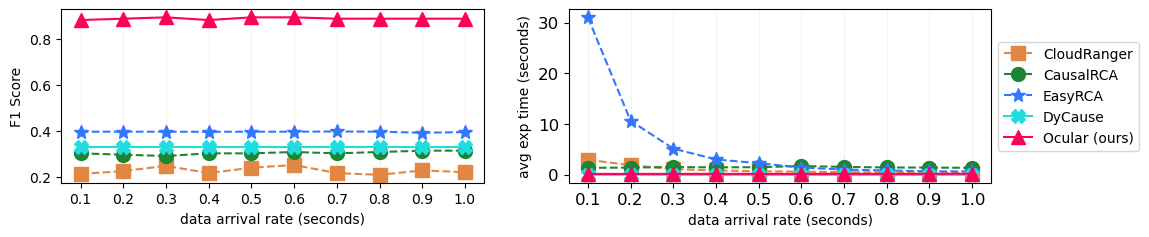

In [3]:
causal_graph_type = 'branch'
possible_root_causes_branch = {3 : ('X1',),
                        4 : ('X1','X3',),
                        5 : ('X1', 'X3', 'X4'),
                        6 : ('X1', 'X4', 'X5'),
                        7 : ('X1', 'X4', 'X5'),
                        8 : ('X1', 'X4', 'X5'),
                        9 : ('X1', 'X4', 'X5'),
                        10 : ('X1', 'X4', 'X5'),
                        11 : ('X1', 'X4', 'X5'),
                        12 : ('X1', 'X4', 'X5')}
rates = (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0)

alg = 'ocular'
folder = f'../{alg}/result/rates/{causal_graph_type}'
shapley_config_str = "AUTO" 
f1_scores_ocular, avg_time_ocular = summarise_performance_metrics(rates, 
                                            possible_root_causes_branch,
                                            num_nodes=6, 
                                            folder=folder,
                                            nslide_used=2)
alg = 'gcm'
folder = f'../{alg}/result/rates/{causal_graph_type}'
shapley_config_str = "AUTO" 
f1_scores_gcm, avg_time_gcm = summarise_performance_metrics(rates, 
                                            possible_root_causes_branch,
                                            num_nodes=6, 
                                            folder=folder,
                                            nslide_used=2)


alg = 'easy_rca'
folder = f'../{alg}/result/rates/{causal_graph_type}'
f1_scores_easyrca, avg_time_easyrca = summarise_performance_metrics(rates, 
                                            possible_root_causes_branch,
                                            num_nodes=6, 
                                            folder=folder,
                                            nslide_used=2)

alg = 'cloudranger'
folder = f'../{alg}/result/rates/{causal_graph_type}'
f1_scores_cloudranger, avg_time_cloudranger = summarise_performance_metrics(rates, 
                                            possible_root_causes_branch,
                                            num_nodes=6, 
                                            folder=folder,
                                            nslide_used=2)

alg = 'dycause'
folder = f'../{alg}/result/rates/{causal_graph_type}'
f1_scores_dycause, avg_time_dycause = summarise_performance_metrics(rates, 
                                            possible_root_causes_branch,
                                            num_nodes=6, 
                                            folder=folder,
                                            nslide_used=2)

rates_str = list(f1_scores_ocular.keys())
rates_str = [f'{i}' for i in rates_str]
f1_ocular = f1_scores_ocular.values()
f1_gcm = f1_scores_gcm.values()
f1_easyrca = f1_scores_easyrca.values()
f1_cloudranger = f1_scores_cloudranger.values()
f1_dycause = f1_scores_dycause.values()

data_dict = {}

data_dict[0] = {'ys': (f1_cloudranger, f1_gcm, f1_easyrca, f1_dycause, f1_ocular), 
                'X'  : rates_str,
                'ylabel' : 'F1 Score',
                'xlabel' : 'data arrival rate (seconds)',
                'lines' : ('--s','--o', '--*', '-X', '-^' ), 
                'labels' : ('CloudRanger', 'CausalRCA', 'EasyRCA', 'DyCause', 'Ocular (ours)'), 
                'colors' : ('#e28743', '#1e8532','#3377FF', '#1fdcde', '#ff005a'),
                'xticks' : None,
                'yticks' : None}
                        
avg_exp_time_ocular = avg_time_ocular.values()
avg_exp_time_gcm = avg_time_gcm.values()
avg_exp_time_easyrca = avg_time_easyrca.values()
avg_exp_time_cloudranger = avg_time_cloudranger.values()
avg_exp_time_dycause = avg_time_dycause.values()

data_dict[1] = {'ys' : (avg_exp_time_cloudranger, avg_exp_time_gcm, avg_exp_time_easyrca, avg_exp_time_dycause, avg_exp_time_ocular),
                'X'  : rates_str,
                'ylabel' : 'avg exp time (seconds)',
                'xlabel' : 'data arrival rate (seconds)',
                'lines' : ('--s','--o', '--*', '-X', '-^' ), 
                'labels' : ('CloudRanger', 'CausalRCA', 'EasyRCA', 'DyCause', 'Ocular (ours)'), 
                'colors' : ('#e28743', '#1e8532','#3377FF', '#1fdcde', '#ff005a'),
                'xticks' : None,
                'yticks' : None}

fig = draw_multiple_plots(data_dict, 
                    nsubplots = 2, figsize=(12,2.25), sharey=False)

pp = PdfPages(f'all_rates_{causal_graph_type}.pdf')
pp.savefig(fig, tight_layout=True, bbox_inches = "tight")
pp.close()